In [1]:
import numpy as np 
import pandas as pd 
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pickle
#import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler 
import torch
from torch import nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.metrics import mean_absolute_error
import tqdm

In [2]:
window_size = 10
max_stock = 200
variables = [#'reference_price',
            #'imbalance_buy_sell_flag',
            'target',
             'yesterday_return',
             'yesterday_target'
             ]
target = 'return'
train = pd.read_csv("./data/train.csv")
stocks = range(0,max_stock)
train = train.sort_values(['date_id','time_id'])
train['wap'] = train['wap'].fillna(train['wap'].mean())
scaler =  MinMaxScaler()
targetScaler = MinMaxScaler()
returnScaler = MinMaxScaler()
#print(train.head())
train['wap_scaled'] = scaler.fit_transform(train['wap'].to_numpy().reshape(-1, 1)).squeeze()
train['target_scaled'] = targetScaler.fit_transform(train['target'].to_numpy().reshape(-1, 1)).squeeze()
train['yesterday'] = train['date_id'] - 1
merged =train.merge(train,how='left',left_on=['yesterday','stock_id','seconds_in_bucket'],right_on=['date_id','stock_id','seconds_in_bucket'],suffixes=['','_yesterday'])

train['yesterday_target'] = merged['target_yesterday']
train['return'] = train['target'] - train['yesterday_target']
train['return'] =  returnScaler.fit_transform(train['return'].to_numpy().reshape(-1, 1)).squeeze()

merged =train.merge(train,how='left',left_on=['yesterday','stock_id','seconds_in_bucket'],right_on=['date_id','stock_id','seconds_in_bucket'],suffixes=['','_2'])

train['yesterday_return'] = merged['return_2']

table = pd.pivot_table(train[train['stock_id']  < max_stock],values=variables + [target],columns=['stock_id'],index=['date_id','time_id'])


table.fillna(method='bfill',inplace=True)
table.fillna(method='ffill',inplace=True)

print(table.head())
table.isna().sum()
with open('targetScaler', 'wb') as handle:
    pickle.dump(targetScaler, handle, protocol=pickle.HIGHEST_PROTOCOL)

                   return                                                    \
stock_id              0         1         2         3         4         5     
date_id time_id                                                               
0       0        0.484462  0.510736  0.502856  0.493693  0.505713  0.494517   
        1        0.484462  0.510736  0.502856  0.493693  0.505713  0.494517   
        2        0.484462  0.510736  0.502856  0.493693  0.505713  0.494517   
        3        0.484462  0.510736  0.502856  0.493693  0.505713  0.494517   
        4        0.484462  0.510736  0.502856  0.493693  0.505713  0.494517   

                                                         ... yesterday_target  \
stock_id              6         7         8         9    ...              190   
date_id time_id                                          ...                    
0       0        0.508318  0.499472  0.488242  0.490351  ...         6.370544   
        1        0.508318  0.499472  0.4882

C:\Users\adams\AppData\Local\Temp\ipykernel_30564\2557313696.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  table.fillna(method='bfill',inplace=True)
C:\Users\adams\AppData\Local\Temp\ipykernel_30564\2557313696.py:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  table.fillna(method='ffill',inplace=True)


In [3]:
rolling_target = {}
rolling_amount = 5
for stock in stocks:
    rolling_target[stock] = table[target][stock].rolling(rolling_amount).mean()
    rolling_target[stock] = rolling_target[stock].fillna(0)

rolling_target_df = pd.DataFrame(rolling_target)
print(rolling_target_df.head())

                      0         1         2         3         4         5    \
date_id time_id                                                               
0       0        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
        1        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
        2        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
        3        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
        4        0.484462  0.510736  0.502856  0.493693  0.505713  0.494517   

                      6         7         8         9    ...       190  \
date_id time_id                                          ...             
0       0        0.000000  0.000000  0.000000  0.000000  ...  0.000000   
        1        0.000000  0.000000  0.000000  0.000000  ...  0.000000   
        2        0.000000  0.000000  0.000000  0.000000  ...  0.000000   
        3        0.000000  0.000000  0.000000  0.000000  ...  0.000000   
  

In [4]:
def create_lagged_data(data,var,window_size,target_data):
    X = np.array([])
    for stock in range(max_stock):
        var_data = pd.DataFrame()
        for i in range(0,len(var)):
            var_data = pd.concat([var_data,data[var[i]][stock]],axis=1,)

        
        var_data = var_data.values.reshape(-1,len(var))
        #print(var_data)
        n = data.shape[0]
        temp_X = np.hstack(tuple([var_data[i: n-j, :] for i, j in enumerate(range(window_size,0,-1))]))
        temp_X = temp_X[:temp_X.shape[0]]
       
        if stock == 0:
            X = temp_X
        else:
            X = np.concatenate((X,temp_X),axis=1) 
    y = target_data.iloc[window_size:]
    y_true = data['target'].iloc[window_size:]
    yesterday_target = data['yesterday_target'].iloc[window_size:]
    y.reset_index()
    return X, y.to_numpy(),y_true.to_numpy(),yesterday_target.to_numpy()

In [5]:
#for stock in stocks:
torch.cuda.empty_cache()
#print("creating forecaster for stock: ",stock)
#X, y, y_true = create_lagged_data(table,['wap_scaled'],window_size,0,target=rolling_target_df)
X, y, y_true,yesterday_target = create_lagged_data(table,variables,window_size,target_data=rolling_target_df)


size = int(X.shape[0]*.9)
X_train = torch.tensor(X[:size]).to(torch.float32)
y_train = torch.tensor(y[:size]).to(torch.float32)
y_train_true = y[:size]
yesterday_target_train = yesterday_target[:size]

X_test = torch.tensor(X[size:]).to(torch.float32)
y_test = torch.tensor(y[size:]).to(torch.float32)
y_test_true = y_true[size:]
yesterday_target_test = yesterday_target[size:]

In [6]:
class TestModel(nn.Module):
    def __init__(self,window_size,features,max_stock):
        super().__init__()
        self.lstm_dic = {}
        ls_hidden = int(window_size * features * (2) + 1)
        for i in range(max_stock):
            self.lstm_dic[i]= nn.LSTM(input_size=window_size * features, hidden_size=ls_hidden, num_layers=1, batch_first=True)
        #self.conv1d = nn.Conv1d(in_channels=window_size * max_stock * features, out_channels=10,kernel_size=2)
        #self.lstm1 = nn.LSTM(input_size=(window_size * features,2), hidden_size=50, num_layers=1, batch_first=True)
        self.bnl1 = nn.BatchNorm1d(ls_hidden*max_stock)
        self.lstm2 = nn.LSTM(input_size=100,hidden_size=50,num_layers=1)
        self.linear1 = nn.Linear(ls_hidden*max_stock, 10000)
        self.elu1 = nn.ELU()
        #self.bn1 = nn.BatchNorm1d(500)
        self.linear2 = nn.Linear(10000, 10000)
        self.elu2 = nn.ELU()
        #self.bn2 = nn.BatchNorm1d(400)
        self.linear3 = nn.Linear(10000, 5000)
        self.elu3 = nn.ELU()

        self.linear4 = nn.Linear(5000,max_stock)
        self.to(torch.float32)
    def forward(self, x):
        #x = self.conv1d(X)
        for i in range(max_stock):
            input = x[:,i*window_size:(i+1)*window_size]
            
            y, _= self.lstm_dic[i](input)
            if i == 0:
                lstm_out = y.squeeze()
            else:
                lstm_out = torch.cat((lstm_out,y),1).squeeze()
            


        #lstm_out = lstm_out.squeeze()
        #x, _ = self.lstm1(x)

        #x = self.bnl1(lstm_out)
        
        #x, _ = self.lstm2(x)
        x = self.linear1(lstm_out)
        x = self.elu1(x)
       # x = self.bn1(x)
        x = self.linear2(x)
        x = self.elu2(x)
        #x = self.bn2(x)
        x = self.linear3(x)
        x = self.elu3(x)
        x = self.linear4(x)
        #x = torch.clip(x,-10,10)
        
        return x.type(torch.float32)

In [7]:
forecaster = TestModel(10,3,200)
forecaster.load_state_dict(torch.load('./lstm_model'))
forecaster.eval()

TestModel(
  (bnl1): BatchNorm1d(12200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm2): LSTM(100, 50)
  (linear1): Linear(in_features=12200, out_features=10000, bias=True)
  (elu1): ELU(alpha=1.0)
  (linear2): Linear(in_features=10000, out_features=10000, bias=True)
  (elu2): ELU(alpha=1.0)
  (linear3): Linear(in_features=10000, out_features=5000, bias=True)
  (elu3): ELU(alpha=1.0)
  (linear4): Linear(in_features=5000, out_features=200, bias=True)
)

In [8]:
y_hat = forecaster(X_test).to('cpu').detach().numpy()
y_train_hat = forecaster(X_train)

#ra =5
#y_hat[y_hat >= ra] = ra
#y_hat[y_hat <= -ra] = -ra


print(mean_absolute_error(y_test.to('cpu').detach().numpy(),y_hat) )
#mean_absolute_error(y_train.to('cpu').detach().numpy(),y_train_hat.to('cpu').detach().numpy())

112.68963


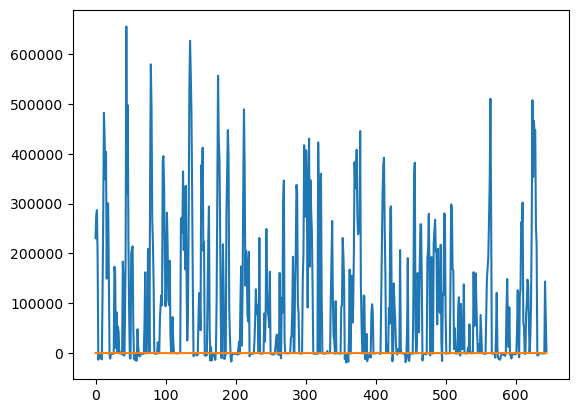

In [9]:
inversed_y_hat = returnScaler.inverse_transform(y_hat)
inversed_y_test = returnScaler.inverse_transform(y_test)

pd.Series(inversed_y_hat[:,0][2000:]).plot()
pd.Series(inversed_y_test[:,0][2000:]).plot()
plt.show()

In [10]:
y_hat = returnScaler.inverse_transform(forecaster(X_test).to('cpu').detach().numpy()) + yesterday_target_test

ra = 10
y_hat[y_hat >= ra] = ra
y_hat[y_hat <= -ra] = -ra


print(mean_absolute_error(y_test_true,y_hat) )

: 

In [ ]:

pd.Series(y_hat[:,1][2200:]).plot()
pd.Series(y_test_true[:,1][2200:]).plot()
plt.show()